## Import libraries

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from math import *
from sklearn.metrics import mean_squared_error,mean_absolute_error
from fbprophet import Prophet
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from mlens import metrics
import itertools

## Load data

In [85]:
sales_df = pd.read_csv("./sales.csv",sep=";")
categories_df = pd.read_csv("./categories.csv",sep=";")
traffic_df = pd.read_csv("./traffic.csv",sep=";")

## Merge table

In [86]:
df = sales_df.merge(traffic_df, on=["product_id",'week_starting_date'],how='left').merge(categories_df, on='product_id', how='inner')

## Fill empty rows

In [87]:
df['traffic'].fillna(0,inplace=True)

In [88]:
df.rename(columns={'week_starting_date':'date'},inplace=True)

## Some information about Dataset

In [89]:
df.head()

,date,product_id,sales,traffic,category_id
0,20191209,1990,1,1.0,0
1,20201123,1990,1,0.0,0
2,20201207,1990,1,0.0,0
3,20191202,1990,1,1.0,0
4,20201109,1990,2,1.0,0


In [90]:
df.describe()

,date,product_id,sales,traffic,category_id
count,1.057810e+05,105781.000000,105781.000000,105781.000000,105781.000000
mean,2.019652e+07,1542.355007,29.750588,25.365689,25.603596
std,4.936736e+03,905.754736,104.557434,89.082039,18.955310
min,2.019011e+07,1.000000,1.000000,0.000000,0.000000
25%,2.019090e+07,737.000000,5.000000,2.000000,10.000000
50%,2.020030e+07,1532.000000,9.000000,7.000000,22.000000
75%,2.020082e+07,2310.000000,21.000000,20.000000,36.000000
max,2.020123e+07,3135.000000,5465.000000,9914.000000,91.000000


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105781 entries, 0 to 105780
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         105781 non-null  int64  
 1   product_id   105781 non-null  int64  
 2   sales        105781 non-null  int64  
 3   traffic      105781 non-null  float64
 4   category_id  105781 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 4.8 MB


## Correlation between variables

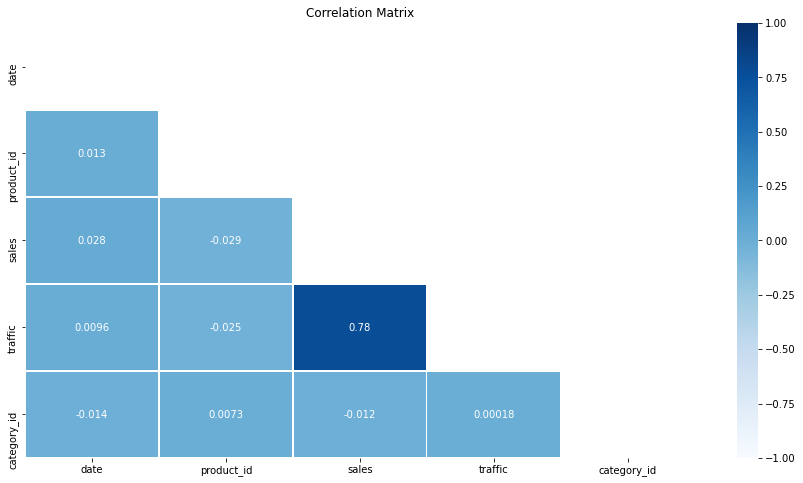

In [92]:
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0)
plt.title('Correlation Matrix')
plt.show()

In [93]:
# Correlation between sales and traffic is quite strong

## Prepare data part 1

In [94]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [95]:
df2 = df.copy(deep=True)

In [96]:
df2['year'] = df['date'].dt.year
df2['month'] = df['date'].dt.month
df2['day'] = df['date'].dt.day

## Some visualization

<AxesSubplot:title={'center':'Sales by Year'}, xlabel='Years', ylabel='Sales in billions'>

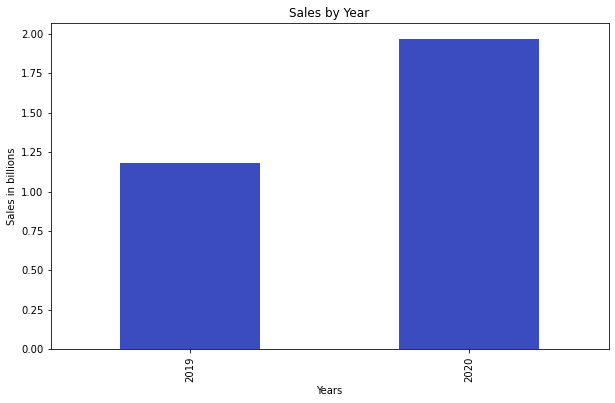

In [97]:
sales_year = df2.groupby('year').agg(sales_target =('sales','sum'))
sales_year=sales_year/1000000
sales_year.plot(kind='bar', title = 'Sales by Year', figsize = (10,6), cmap='coolwarm', xlabel="Years",ylabel="Sales in billions",legend=False)

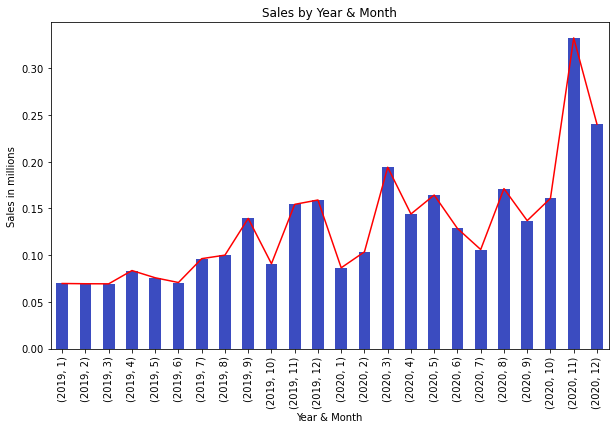

In [98]:
sales_year_month = df2.groupby(['year','month']).agg(sales_target =('sales','sum'))
sales_year_month=sales_year_month/1000000
ax=sales_year_month.plot(kind='line', title = 'Sales by Year & Month', figsize = (10,6), color='red', xlabel="Year & Month",ylabel="Sales in millions",legend=False)
sales_year_month.plot(kind='bar', title = 'Sales by Year & Month', figsize = (10,6), cmap='coolwarm', xlabel="Year & Month",ylabel="Sales in millions",legend=False,ax=ax);

<AxesSubplot:title={'center':'Best 10 selling product_id'}, xlabel='Product ID', ylabel='Sales'>

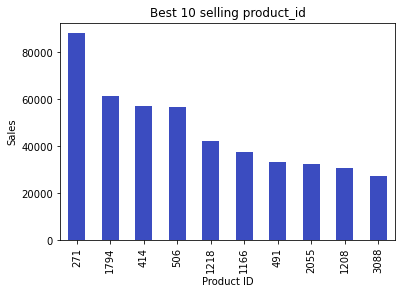

In [99]:
best_product = pd.DataFrame(df2.groupby('product_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods.plot(kind="bar", title = 'Best 10 selling product_id', cmap='coolwarm', xlabel="Product ID",ylabel="Sales",legend=False)

<AxesSubplot:title={'center':'Best 10 selling category_id'}, xlabel='Category ID', ylabel='Sales'>

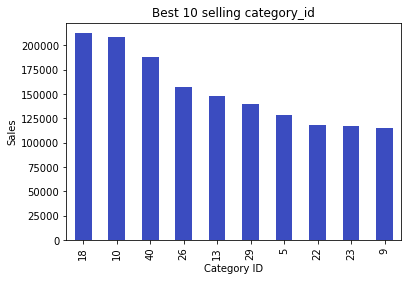

In [100]:
best_product = pd.DataFrame(df2.groupby('category_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods.plot(kind="bar", title = 'Best 10 selling category_id', cmap='coolwarm', xlabel="Category ID",ylabel="Sales",legend=False)

## Prepare data part 2

In [101]:
data=df.groupby(['date']).agg({'traffic': 'sum','sales': 'sum','category_id':'count'}).reset_index()
data = data.set_index('date')
data.head()

,traffic,sales,category_id
date,,,
2019-01-07,17856.0,16958,692
2019-01-14,18113.0,18187,708
2019-01-21,19897.0,18344,727
2019-01-28,10042.0,16164,729
2019-02-04,13492.0,18168,739


In [102]:
print("missing_data:", data.isna().sum())
print("unique dates:", data.index.nunique())

missing_data: traffic        0
sales          0
category_id    0
dtype: int64
unique dates: 104


## Visualise the data

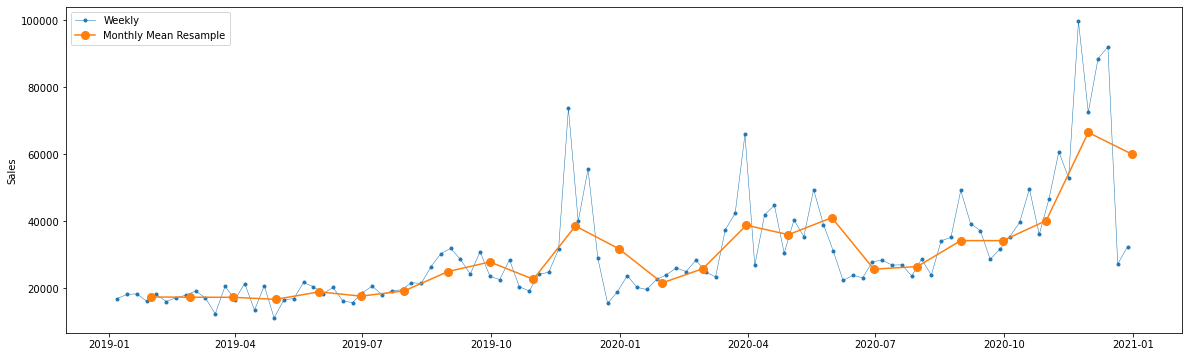

In [103]:
y = data[['sales']]
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sales')
ax.legend();

In [104]:
#By looking at the graph of sales data above, we can see a general increasing trend with no clear pattern
#of seasonal or cyclical changes

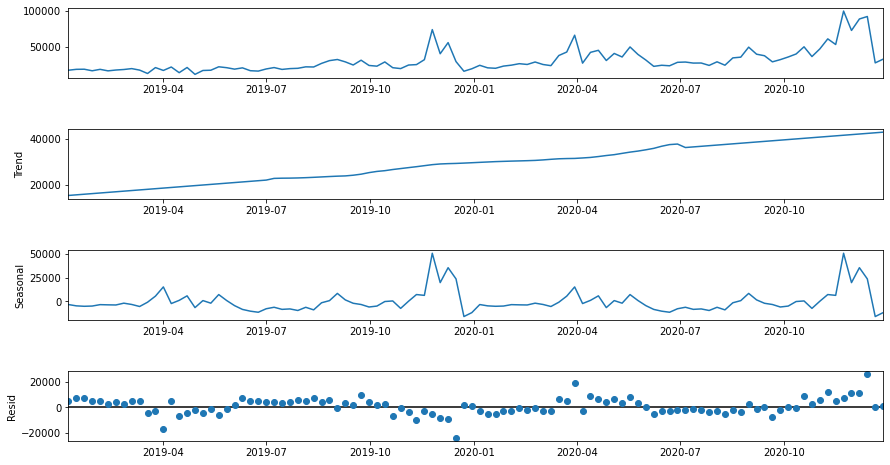

In [105]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()


In [106]:
#After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing
#trend as well as a yearly seasonality.

## Check for stationarity

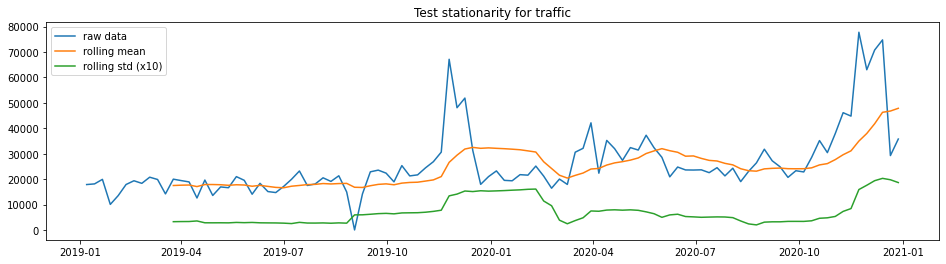

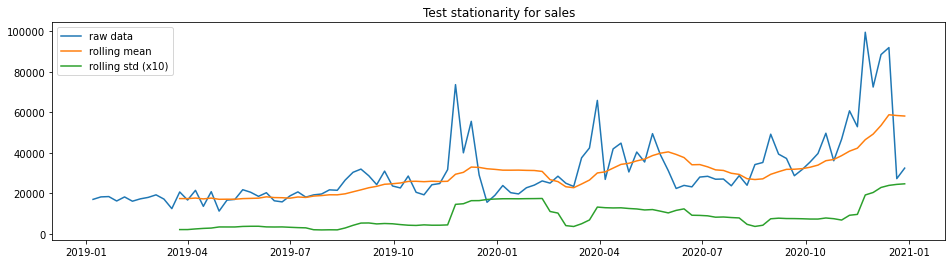

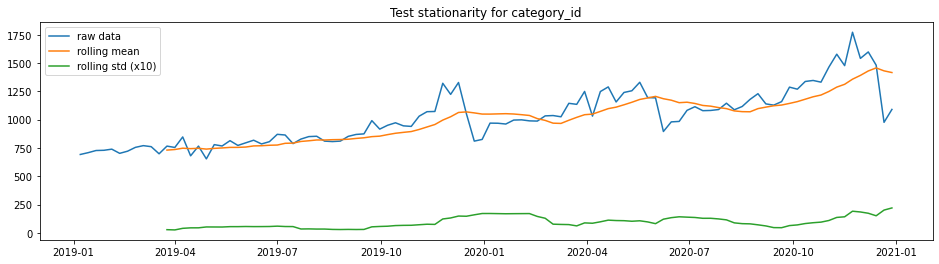

In [107]:
for col in data.columns:
    y = data[col]
    rolmean = pd.Series(y).rolling(window=12).mean() 
    rolstd = pd.Series(y).rolling(window=12).std()   
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y, label= 'raw data')
    ax.plot(rolmean, label='rolling mean')
    ax.plot(rolstd, label='rolling std (x10)')
    plt.title("Test stationarity for {}".format(col))
    ax.legend()


In [108]:
#In all 3 graphs both the mean and standard deviation for stationary data does not change much over time But in this case,
#since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing 
#the above graph.

In [109]:
for col in data.columns:
    y = data[col]
    print('Is the {} stationary ?'.format(col))
    test = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(test[0]))
    print('P-value = {:.3f}'.format(test[1]))
    print('Critical values :')
    for k, v in test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))
    print("-"*100)

Is the traffic stationary ?
Test statistic = -2.531
P-value = 0.108
Critical values :
	1%: -3.498198082189098 - The data is not stationary with 99% confidence
	5%: -2.891208211860468 - The data is not stationary with 95% confidence
	10%: -2.5825959973472097 - The data is not stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the sales stationary ?
Test statistic = -2.782
P-value = 0.061
Critical values :
	1%: -3.498198082189098 - The data is not stationary with 99% confidence
	5%: -2.891208211860468 - The data is not stationary with 95% confidence
	10%: -2.5825959973472097 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the category_id stationary ?
Test statistic = -2.059
P-value = 0.262
Critical values :
	1%: -3.4961490537199116 - The data is not stationary with 99% confidence
	5%: -2.8903209639580556 

In [110]:
# For 3 columns the p-value is greater than the significance level 0.05, so we stay with the null hypothesis and 
#conclude that the data are non-stationary

## Make the data stationary

In [111]:
# Detrending
for col in data.columns:
    y = data[col]
    y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()
    data[col] = y_detrend
    
for col in data.columns:
    y = data[col]
    print('Is the {} stationary ?'.format(col))
    test = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(test[0]))
    print('P-value = {:.3f}'.format(test[1]))
    print('Critical values :')
    for k, v in test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))
    print("-"*100)

Is the traffic stationary ?
Test statistic = -5.117
P-value = 0.000
Critical values :
	1%: -3.503514579651927 - The data is  stationary with 99% confidence
	5%: -2.893507960466837 - The data is  stationary with 95% confidence
	10%: -2.583823615311909 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the sales stationary ?
Test statistic = -4.566
P-value = 0.000
Critical values :
	1%: -3.506057133647011 - The data is  stationary with 99% confidence
	5%: -2.8946066061911946 - The data is  stationary with 95% confidence
	10%: -2.5844100201994697 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the category_id stationary ?
Test statistic = -4.897
P-value = 0.000
Critical values :
	1%: -3.503514579651927 - The data is  stationary with 99% confidence
	5%: -2.893507960466837 - The data is  stati

In [112]:
"""print(data['sales'].isnull().sum())
print(data['traffic'].isnull().sum())
print(data['category_id'].isnull().sum())"""

"print(data['sales'].isnull().sum())\nprint(data['traffic'].isnull().sum())\nprint(data['category_id'].isnull().sum())"

In [113]:
# Now we can see that everything is stationary because p-value < 0.05 

## Create Training & Testing Datasets

In [118]:
train = data[:'2020-05-04']
test = data['2020-05-04':]
data.fillna(method='ffill',inplace=True)

In [119]:
train = train.reset_index()[['date','sales','traffic','category_id']].rename({'date':'ds','sales':'y'}, axis='columns')
test = test.reset_index()[['date','sales','traffic','category_id']].rename({'date':'ds','sales':'y'}, axis='columns')
#print(new_df['y'].isnull().sum())
#print(new_df['traffic'].isnull().sum())
#print(new_df['category_id'].isnull().sum())
#new_df.head()

## Prophet

In [145]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2019-06-24 00:00:00 and 2020-04-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000174EE58B3D0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2019-06-24 00:00:00 and 2020-04-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.

INFO:fbprophet:Making 20 forecasts with cutoffs between 2019-06-24 00:00:00 and 2020-04-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000174EB871F10>


    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  1.369720
1                     0.001                     0.10  1.369720
2                     0.001                     1.00  1.369720
3                     0.001                    10.00  1.369720
4                     0.010                     0.01  1.340838
5                     0.010                     0.10  1.340838
6                     0.010                     1.00  1.340838
7                     0.010                    10.00  1.340838
8                     0.100                     0.01  1.340733
9                     0.100                     0.10  1.340733
10                    0.100                     1.00  1.340733
11                    0.100                    10.00  1.340733
12                    0.500                     0.01  1.427518
13                    0.500                     0.10  1.427518
14                    0.500                     1.00  1

In [151]:
best_params = all_params[np.argmin(rmses)]
print("The best parameters => {}".format(best_params))

The best parameters => {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [152]:
model = Prophet(**params,interval_width=0.95,yearly_seasonality=True)
model.fit(train)
future_test = model.predict(df=test.rename(columns={'date':'ds','sales':'y'}))
#future = model.make_future_dataframe(periods=3, freq='t')

future = model.make_future_dataframe(periods=3, freq='t')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Model fitting

<AxesSubplot:xlabel='ds'>

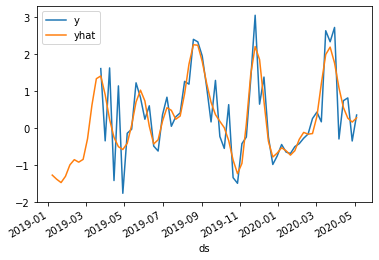

In [153]:
pd.concat([train.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

In [154]:
#We can see that the model has fitted the data reasonably well but not excessively 

## Plot prediction test data

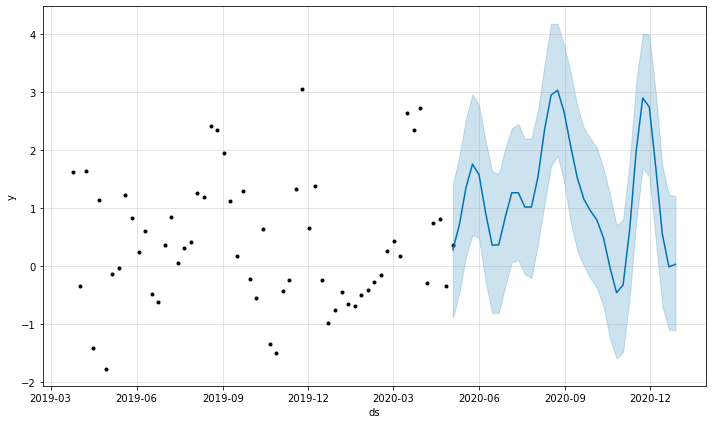

In [155]:
fig1 = model.plot(future_test)

In [156]:
#fig1 = model.plot(forecast)

## Plot the components of the model

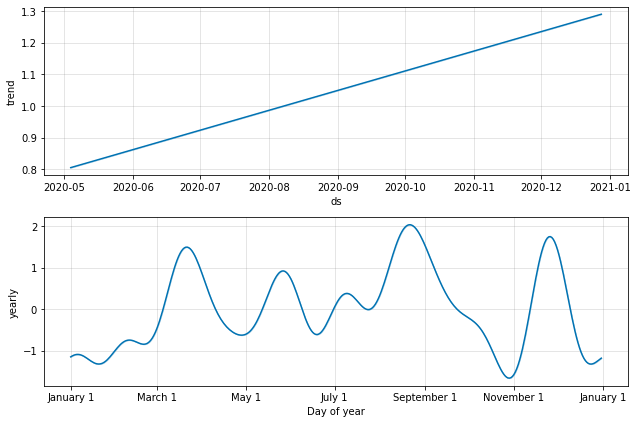

In [157]:
fig2 = model.plot_components(future_test)

In [158]:
## We can see that dataset has an overall increasing trend and certain seasonality 

## Metrics for model

In [159]:
wape=metrics.wape(test["y"],future_test["yhat"])
print("Weighted Absolute Percent Error = {}".format(wape))
mse=mean_squared_error(test["y"],future_test["yhat"])
print("Mean Squared Error = {}".format(mse))
mae=mean_absolute_error(test["y"],future_test["yhat"])
print("Mean Absolute Error = {}".format(mae))
mape=metrics.mape(test["y"],future_test["yhat"])
print("Mean Average Percentage Error = {}".format(mape))

Weighted Absolute Percent Error = 1.190885867135196
Mean Squared Error = 1.9834947547776047
Mean Absolute Error = 1.2156305118470143
Mean Average Percentage Error = 3.393077608815926


In [137]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation( model = model, initial = '21 days', horizon = '100 days')


INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-05-20 00:00:00 and 2020-01-25 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [ ]:
cv_results.head()

In [138]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p


,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,52.705369,7.259846,5.196807,13.571399,5.545126,0.375
1,11 days,91.409651,9.560839,7.234602,14.713309,6.733743,0.375
2,12 days,87.975587,9.379530,6.969749,14.640005,6.733743,0.375
3,13 days,83.523825,9.139137,6.604110,15.800490,9.832571,0.375
4,14 days,84.573959,9.196410,6.856065,17.314274,12.252885,0.250
...,...,...,...,...,...,...,...
73,95 days,95.607420,9.777905,6.595985,18.395193,3.148361,0.500
74,96 days,59.620458,7.721428,5.378288,14.674706,3.148361,0.500
75,97 days,59.592033,7.719588,5.362006,14.650464,3.051394,0.500
76,98 days,59.569872,7.718152,5.350481,14.658227,3.051394,0.500


In [140]:
####

In [ ]:
pro_change= Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [ ]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)